# Final project machine learning for NLP

## Overview of the project

Now that you're sort of acquainted with the IMDb database, we'll stick to it and build various flavors of text classification models with machine learning approaches. You will be able to compare these approaches to the vector space model with tf-idf weighting that we played with in lecture 2.

The project pursues two goals:
1. better understand transformers and pre-trained large language models
2. get familiar with the (keras) implementation of various machine learning approaches for text classification

Extension to tagging tasks is rather straightforward once you've mastered text classification. We won't consider tagging as part of the project but if you're interesting in going further, I'm providing a step-by-step guided labwork (text only, no noteboook) to design a LSTM-based tagger in keras. It also features basic approaches to text classification and details on how to manipulate tensorflow datasets. You can  of course get inspired from this labwork in implementing your project.

## Content of the project

The project's notebook (this one!) has already a number of things coded for you to get started and instructions of what to do (and sometimes hints on how to do it) in the corresponding cells. We will go throught the following steps:

1. Play with BERT tokenizer
  - get acquainted with BERT's word piece tokenizer (instructions provided below)
  - load IMDb data and tokenize the sequences (with padding)

2. Play with BERT embeddings
  - get acquainted with the output of a BERT encoder (instructions provided below)
  - choose a few tokens that appear several times in the data
  - visualize (with t-SNE) their embeddings at the input, at the output and in one of the middle layer
  - visualize utterance embeddings (differentiating classes) -- [CLS] token, pooler, average word embedding

3. Develop a basic classification model
  - each utterance is represented as a single embedding (choose one of the above)
  - build a feed-forward classifier on top (hints on how to do that with keras below)

4. LSTM classifiction (using BERT's tokenizer)
  - each utterance is represented as a fixed-length sequence of token IDs
  - build a LSTM classifier on top of it (adapt the LM example from lecture 3)

5. BERT fine-tuning
  - each utterance is represented as a fixed-length sequence of token IDs (plus attention masks and token type IDs)
  - fine-tune a BERT encoder with a classification head (same as in 3 but the BERT encoder is also (re)trained)
  
## A few general hints

- We will make simple use of keras interfaces for training and not bother with tensorflow datasets and the likes. This means we will pass on arrays to model.fit(), leaving batching to the fit() function. As a consequence, you will need to shuffle the dataset that comes with all positive examples followed by all negative examples. Here's an easy way to shuffle elements in a list:

        buf = np.arrange(100)
        p = np.random.permutation(len(buf))
        buf = buf[p]

- Currently, the data you have is not divided into train, validation and test set: you will thus have to split the data in a 60/20/20 proportion, keeping in mind that the classes in each subset must be balanced (same number of samples).

- We will represent the class as a single integer, 0 for negative comments and 1 for positive comments. Hence the text classification task boils down to predicting a single value, either 0 or 1. The loss function corresponding to such a setting is the binary crossentropy (keras.losses.BinaryCrossentropy() or simply loss='binary_crossentropy'). The sparse categorical crossentropy can also be used (and should theoretically be equivalent in this case). As a performance metric to monitor training on the validation set, you can use accuracy or BinaryAccuracy().

- Training LSTMs and fine-tuning BERT becomes computationnaly expensive on CPU: it's thus better ot use a GPU. If you have CUDA installed on your machine, this should be transparent and tensorflow/keras should directly make use of the GPU. You can also go to Google Colaboratory (or any other similar framework): in this case, be aware that you're data (including trained models) will be lost when the session ends unless you save them elsewhere (e.g., in a drive or something like this).

## Project report

I am expecting you to hand over a report of your project which will take the form of a commented notebook. I'm not so much interested about the coding quality and rather concentrate on your intepretation of what you do and why you do it one way or the other. I'm thus expecting a notebook with a (huge) lot of comments! For instance, I want you to briefly reexplain what the models are doing from a theoretical point of view for step 3, 4 and 5 before running the implementation (concretely, briefly reexplain what we saw in the classroom). I also want you to comment the results and analyze a few examples that were misclasified, trying to figure out why and, if possible, relate this to the limits of the classification method used. I'm also expecting thoughts on how things could be improved. Don't expect me to simply run your notebook and check that it works: in most cases, I will not even try to run things and simply look at the comments and analyses you will provide.


In [ ]:
import json
import numpy as np
from tqdm import tqdm

from transformers import BertTokenizer
from transformers import TFBertModel
import tensorflow as tf
import keras
import keras.layers as layers
from keras.callbacks import ModelCheckpoint

from tensorflow.keras.utils import plot_model

## Play with BERT tokenizer and embeddings

We will load a pre-trained MLM BERT model and the corresponding tokenizer. This is done by specifying a _checkpoint_ that designates the model to load from the Huggingface library of models. Note that there are many variants of BERT models to play with: see Huggingface models.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108310272 (413.17 MB)
Trainable params: 108310272 (413.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


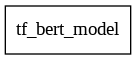

In [ ]:
#
# Let's load a standard BERT model along with the corresponding tokenizer
# from the Huggingface library. Note that the tokenizer and model can be
# loaded directly in Keras with tensorflow_hub without resorting to HugginfFace
# library. But we'll go the simple way here.
#

checkpoint = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(checkpoint)
encoder = TFBertModel.from_pretrained(checkpoint, output_hidden_states=True)

encoder.summary()
plot_model(encoder)

In [ ]:
#
# Let's first play with the tokenizer to see what it does and looks like
#

inputs = tokenizer("This is a test sentence to run through a transformer.", return_tensors="tf")

print(inputs)
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
print(len(tokens), tokens)

# The tokenizer outputs three things:
#   - list of token ids as a result of the tokenization
#   - attention mask to tell whether attention should consider this token or not (because of padding)
#   - token type to separate multiple utterances in the case of multiple input
#
# The two functions convert_ids_to_tokens() and decode() are useful to see what's going on behind
# the scene.


#
# We can also pass on a pair of utterances to encode them into a single sequence: they are
# separated by the special [SEP] token and the token_type attribute enables attributing tokens
# to one utterance or the other.
#
print('\n-----\n')
inputs = tokenizer("This is a first sentence.", "Followed by a second.", return_tensors="tf")

print(inputs)
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
print(len(tokens), tokens)

#
# Another use of the tokenizer is to encore multiple utterances, possibly with padding as
# below. Note in this case the attention_mask attribute for the shortest sentence that
# tells (self-)attention should disregard the padding tokens.
#
# Q: Any idea why we need attention masks, or, said differently, why we shouldn't have attention
# on the padding tokens?
# Response:
print('\n-----\n')
texts = ["This is a sentence longer than the second one.", "Followed by a second."]
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="tf")
# the fact that adding 'padding' will split the text in two separates sentences.

print(inputs)
print("length of the input:", len(inputs['input_ids']))
for i in range(len(inputs['input_ids'])):
    buf = tokenizer.convert_ids_to_tokens(inputs['input_ids'][i])
    print(len(buf), buf)


{'input_ids': <tf.Tensor: shape=(1, 14), dtype=int32, numpy=
array([[  101,  1188,  1110,   170,  2774,  5650,  1106,  1576,  1194,
          170, 11303,  1200,   119,   102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 14), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 14), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}
14 ['[CLS]', 'This', 'is', 'a', 'test', 'sentence', 'to', 'run', 'through', 'a', 'transform', '##er', '.', '[SEP]']

-----

{'input_ids': <tf.Tensor: shape=(1, 15), dtype=int32, numpy=
array([[  101,  1188,  1110,   170,  1148,  5650,   119,   102, 19253,
         1174,  1118,   170,  1248,   119,   102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 15), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 15), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1,

In [ ]:
outputs = encoder(inputs)

print(outputs.keys())
print('Contextual embedding for inputs in last_hidden_state with shape', outputs['last_hidden_state'].shape)
# the last hidden states of the encoder has dimension 2 (because 2 sentences), 12 (the lengths of the sentences), 768 (because size of the hidden state for each token)
print('All embeddings in hidden_states with', len(outputs['hidden_states']), 'layers')

#
# The contextual embedding that comes out of the encoder can be found in
# outputs['last_hidden_state']: this is taken before the classification head (if any) and
# contains the contextual representations of each input token after going through all the
# transformer blocks.
#
# We can access the intermediate representations at input and after each transformer block
# through outputs['hidden_states']: this is a list that contains the contextual representations
# of each token at the input (outputs['hidden_states'][0]) and after each of the 12 layers.
# After the 12th layer, outputs['hidden_states'][-1] is thus the same as outputs['hidden_states']
# which we can easily verify:
#

print('Shape of the outputs[hidden_states]:', len(outputs['hidden_states']))
print('Shape of the outputs[hidden_states][0]:', outputs['hidden_states'][0].shape)
print('Shape of the outputs[hidden_states][0][0]:', outputs['hidden_states'][0][0].shape)
print('Shape of the outputs[hidden_states][0][0][:20]:', outputs['hidden_states'][0][0][:20].shape)
print('\n-----\n')
print(outputs['last_hidden_state'][0][0][:20])
print(outputs['hidden_states'][-1][0][0][:20])

#
# The pooler_output argument is a sentence embedding corresponding to the last layer
# hidden-state of the first token of the sequence further processed by a linear layer
# and a Tanh activation function with weights trained for the next sentence prediction
# task -- see https://github.com/huggingface/transformers/issues/7540.
#

print(outputs[0])


#
# Q: What is the dimension of the output token embedding space?
#
# We know that the size of the hidden state for each token is 768 so:
print('The dimension of the output token embedding space is:', outputs['last_hidden_state'].shape[2])

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])
Contextual embedding for inputs in last_hidden_state with shape (2, 12, 768)
All embeddings in hidden_states with 13 layers
Shape of the outputs[hidden_states]: 13
Shape of the outputs[hidden_states][0]: (2, 12, 768)
Shape of the outputs[hidden_states][0][0]: (12, 768)
Shape of the outputs[hidden_states][0][0][:20]: (12, 768)

-----

tf.Tensor(
[ 0.2579348  -0.03707328  0.09275737 -0.13268834  0.14971311  0.04284838
  0.06445593 -0.34800452  0.09467765 -1.1303687  -0.42358     0.10616682
 -0.120244    0.2246087  -0.5900549  -0.12407957  0.39927572  0.01370177
 -0.24529345 -0.32878557], shape=(20,), dtype=float32)
tf.Tensor(
[ 0.2579348  -0.03707328  0.09275737 -0.13268834  0.14971311  0.04284838
  0.06445593 -0.34800452  0.09467765 -1.1303687  -0.42358     0.10616682
 -0.120244    0.2246087  -0.5900549  -0.12407957  0.39927572  0.01370177
 -0.24529345 -0.32878557], shape=(20,), dtype=float32)
tf.Tensor(
[[[ 0.2579348  

The version shown above is the "Base" version of BERT. It consists of 12 encoders. The BERT architecture is the following:

**Input layer**

*   BERT takes tokenized input sequences, where each token represents a word.

**Embedding Layer**

*   Input embeddings
*   Position embeddings.

**Transformer Encoder**

*   Consists of multiple layers of transformer encoders. Each encoder layer has self-attention mechanisms and a feedforward network, allowing the model to capture contextual information by considering the entire input sequence. (bidirectional)

**Output**

* The output of the encoder is a sequence of hidden states for each token in the input sequence.
*  Learn to predict masked words in a sentence or next sentence prediction.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#
# Load IMDb data and process a small number of samples to play with. You will play later on with the full
# dataset for training. Here, we just want to play a bit with the embeddings.
#

fn = "/content/drive/My Drive/Smart-Data/NLP/imdb-trn.json"

with open(fn, 'rt') as f:
    imdb_data = json.load(f)

small = imdb_data[:2000] + imdb_data[-2000:]

print(len(small))
print(small[0])
print(small[-1])

#
# We will now process the data with the tokenizer and create the labels
#

X = tokenizer([x[1] for x in small], return_tensors="tf", padding=True, truncation=True)
y = [1 if x[0] == 'pos' else 0 for x in small]

print('First sample after tokenization')
print('intput_ids =', tokenizer.convert_ids_to_tokens(X['input_ids'][0]))
print('label =', y[0])

print('\nLast sample after tokenization')
print('intput_ids =', tokenizer.convert_ids_to_tokens(X['input_ids'][-1]))
print('label =', y[-1])

4000
['pos', 'For a movie that gets no respect there sure are a lot of memorable quotes listed for this gem. Imagine a movie where Joe Piscopo is actually funny! Maureen Stapleton is a scene stealer. The Moroni character is an absolute scream. Watch for Alan "The Skipper" Hale jr. as a police Sgt.']
['neg', 'Not that I dislike childrens movies, but this was a tearjerker with few redeeming qualities. M.J. Fox was the perfect voice for Stuart and the rest of the talent was wasted. Hugh Laurie can be amazingly funny, but is not given the chance in this movie. It´s sugar-coated sugar and would hardly appeal to anyone over 7 years of age. See Toy Story, Monsters Inc. or Shrek instead. 3/10']
First sample after tokenization
intput_ids = ['[CLS]', 'For', 'a', 'movie', 'that', 'gets', 'no', 'respect', 'there', 'sure', 'are', 'a', 'lot', 'of', 'memorable', 'quotes', 'listed', 'for', 'this', 'g', '##em', '.', 'Imagine', 'a', 'movie', 'where', 'Joe', 'Pi', '##sco', '##po', 'is', 'actually', 'funn

In [ ]:
import spacy.cli
spacy.cli.download("en_core_web_md")
process = spacy.load('en_core_web_md')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
#
# TODO
#
# You're turn to play now that we have tokenized data and know how to run them through a BERT model to get
# the tokens' embeddings. What we want to do first is visualize the embedding space as we did in lecture 1:
# the difference is that we will do it on a token per token basis rather than globally for all tokens. So
# what you have to do here is:
#   - make a list of tokens that appear in the data (excluding padding) along with the number of times they appear
#   - choose a token that appears several times (typically between 50 and 100)
#   - retrieve the embeddings of each occurrence of this token in the data, at the entrance of the encoder (layer 0) and at the output
#   - make a t-SNE visualization of the token embeddings for the entrance embeddings and for the output embeddings
#
# Remember that the adequate distance between two embeddings is the cosine similarity. You can get inspiration from
# the notebook we used in lecture 1 to visualize word2vec embeddings.
#
# Q: Comment the results and the impact of BERT embedding. If we were to take word2vec embeddings, how many points
# would we have in the embedded space for the token.
#

In those 4 cells below, the goal is **to visualize the embedding space of all occurences of the word 'respect'**.

In [ ]:
######         ######
###### MY WORK ######
######         ######

# 1- Visualize the embedding space

# a- Make a list of tokens that appear in the data (excluding padding)

data = []
for i in range(len(X['input_ids'])):
    # Convert the sample's input_ids to tokens
    tokens = tokenizer.convert_ids_to_tokens(X['input_ids'][i])
    # Remove padding tokens
    tokens_without_padding = [token for token in tokens if token != tokenizer.pad_token]
    # Append the tokens without padding to the list
    data.append(tokens_without_padding)

print(data[0])

['[CLS]', 'For', 'a', 'movie', 'that', 'gets', 'no', 'respect', 'there', 'sure', 'are', 'a', 'lot', 'of', 'memorable', 'quotes', 'listed', 'for', 'this', 'g', '##em', '.', 'Imagine', 'a', 'movie', 'where', 'Joe', 'Pi', '##sco', '##po', 'is', 'actually', 'funny', '!', 'Maureen', 'St', '##ap', '##leton', 'is', 'a', 'scene', 'steal', '##er', '.', 'The', 'Mo', '##ron', '##i', 'character', 'is', 'an', 'absolute', 'scream', '.', 'Watch', 'for', 'Alan', '"', 'The', 'Ski', '##pper', '"', 'Hale', 'j', '##r', '.', 'as', 'a', 'police', 'Sgt', '.', '[SEP]']


In the cell above, I used the token ids from the IMDb dataset and for each sequence of ids (for each sentence), I converted it into tokens. Then I removed the padding from each resulting sequence. Finally, the list `data` is composed of sequences of tokens without padding. `data` is actually a list of lists of sentences containing some tokens. I printed `data[0]` which is the first sentence of the dataset.

In [ ]:
from collections import Counter

# b- Choose a token that appears several times (typically between 50 and 100)

# Flat the list
flat_data = [token for sublist in data for token in sublist]

# Count the occurrences of each token
token_counts = Counter(flat_data)

# Select all the tokens that appear between 50 and 100 times
selected_tokens = [token for token, count in token_counts.items() if 50 <= count <= 100]
print('Selected tokens:', selected_tokens)

# Choose a token that appears between 50 and 100 times
print('Choose the token:', selected_tokens[0])

Selected tokens: ['respect', 'memorable', 'Pi', 'Mo', 'Watch', 'Alan', '##rre', 'filled', '##my', 'pay', 'suicide', 'mood', 'Ra', 'charming', 'moves', 'creepy', '##ab', 'detective', 'nearly', 'Ko', 'shock', 'solid', 'Matt', '##ha', '##ton', 'sit', 'theater', 'upon', 'Fr', 'Billy', 'popular', 'Po', 'giant', 'com', 'da', 'Death', 'immediately', '##lea', 'kills', 'Once', 'discovered', 'win', 'dream', '##ving', 'met', '##tro', '##up', 'Like', 'rated', 'brothers', 'delight', 'addition', 'secret', 'beautifully', 'acted', 'incredible', 'gone', 'reasons', 'Ms', 'clever', '##hr', 'break', 'successful', '##rat', '##MD', 'favourite', 'seven', '##ST', '##M', 'MA', 'perfectly', 'situation', 'dog', 'lovely', 'touch', 'within', 'genius', '##IS', 'powerful', '##per', 'showed', 'terms', 'values', 'Love', 'Q', '##AR', 'Ma', '##am', 'Here', '##OW', 'issues', 'cu', 'Ho', '##rn', 'eye', 'store', 'th', '##ger', '##off', '##mer', 'meets', 'hear', '##int', '##da', 'slightly', '##be', 'business', 'trip', 'stat

In the cell above, I flatted the list data called `flat_data`. It contains all the sentences of the dataset where we can access the tokens more easely than before. By using the library `Counter` from *collection* it allows to count all the occurences of each token. Then I selected all the occurences of each word in the dataset which appears between 50 and 100 times. Finally, I selected the first value of the list of words that contain occurences which gave me the word 'respect'.  

In [ ]:
# c- Retrieve the embeddings of each occurrence of this token in the data, at the entrance of the encoder (layer 0) and at the output

# Get indices of occurrences of the selected token in the data
occurrence_indices = [(i, j) for i, sublist in enumerate(data) for j, token in enumerate(sublist) if token == selected_tokens[0]]
print('Occurences indices of the word "respect":', occurrence_indices)
print('Number of occurences of the word "respect":', len(occurrence_indices))

# Create a list of sentences containing the token "respect"
occurrences_dataset = [small[i][1] for i, j in occurrence_indices]

# Tokenize all sentences at once
input_tensor = tokenizer(occurrences_dataset, return_tensors="tf", padding=True, truncation=True)

# Get embeddings at the entrance of the encoder (layer 0)
entrance_output = encoder(input_tensor)['hidden_states'][0]
print("Shape of entrance_output:", entrance_output.shape)

# Get embeddings at the output
output_output = encoder(input_tensor)['hidden_states'][-1]
print("Shape of output_output:", output_output.shape)

entrance_embeddings = []
output_embeddings = []
k = 0
for i, j in occurrence_indices:
    entrance_embeddings.append(entrance_output[k, j].numpy())
    output_embeddings.append(output_output[k, j].numpy())
    k+=1

# Convert them into arrays
entrance_embeddings = np.array(entrance_embeddings)
output_embeddings = np.array(output_embeddings)

print('Shape of the entrance embeddings (layer 0):', entrance_embeddings.shape)
print('Shape of the output embeddings:', output_embeddings.shape)

Occurences indices of the word "respect": [(0, 7), (50, 86), (87, 158), (88, 179), (93, 69), (136, 69), (217, 166), (268, 486), (276, 152), (340, 140), (372, 29), (385, 313), (389, 178), (400, 347), (423, 62), (514, 79), (572, 166), (782, 126), (805, 109), (830, 439), (855, 109), (925, 193), (947, 263), (975, 326), (1020, 237), (1067, 292), (1103, 93), (1138, 385), (1176, 263), (1261, 274), (1325, 310), (1335, 35), (1336, 350), (1356, 236), (1399, 220), (1494, 398), (1511, 91), (1524, 432), (1576, 357), (1594, 317), (1677, 159), (1683, 80), (1761, 87), (1802, 64), (1947, 201), (2039, 14), (2052, 99), (2073, 150), (2133, 507), (2282, 276), (2282, 305), (2410, 154), (2501, 290), (2501, 299), (2527, 82), (2574, 36), (2646, 333), (2793, 267), (2922, 161), (2998, 253), (3043, 383), (3102, 216), (3161, 187), (3197, 200), (3292, 186), (3299, 29), (3330, 285), (3333, 391), (3409, 334), (3507, 62), (3527, 279), (3529, 235), (3555, 469), (3564, 192), (3593, 214), (3593, 376), (3675, 116), (3691,

In line 4 of the cell above, `occurences_indices` retrieve a tuple composed of the indices $i$ and $j$. $i$ is the index  which represent the position of the sentence containing the word 'respect' in the list `data`. $j$ is the index which represent the position of the token  'respect' in each of the sentences.

The aim here is to compute the embeddings of each occurrence of the word "respect". For this purpose, we use the function `tokenizer` from BERT which tokenize all the sentences where the word 'respect' appears in the dataset. Then, by using the `encoder` function, we compute the embeddings at the entrance of the encoder (line 15) and at the output of the encoder (line 19).

* The variable `entrance_output` holds the hidden states of the first layer of the BERT model for the given input. It's a tensor with dimensions [batch size, sequence length, hidden size]. In this case, `batch size` is equal to the number of occurences in the data. In line 26, the first index '$k$' corresponds to the index of the sequence, the second index '$j$' corresponds to the position of the selected token in the sequence.  So `entrance_output[k,j]` retrieve the embedding of the selected token at position '$j$' within the sentence at index '$k$' in the entrance_output tensor. The shape is then (768, ) for each embedding (for each occurence). The method `numpy` is then used to convert the Tensorflow tensor to a numpy array for further processsing and visualization.

* The variable `output_output` extracts the hidden states from the last layer of the BERT model. The rest is the same as for `entrance_output`.

Shape of the projection entrance_tsne: (83, 2)
Shape of the projection output_tsne: (83, 2)


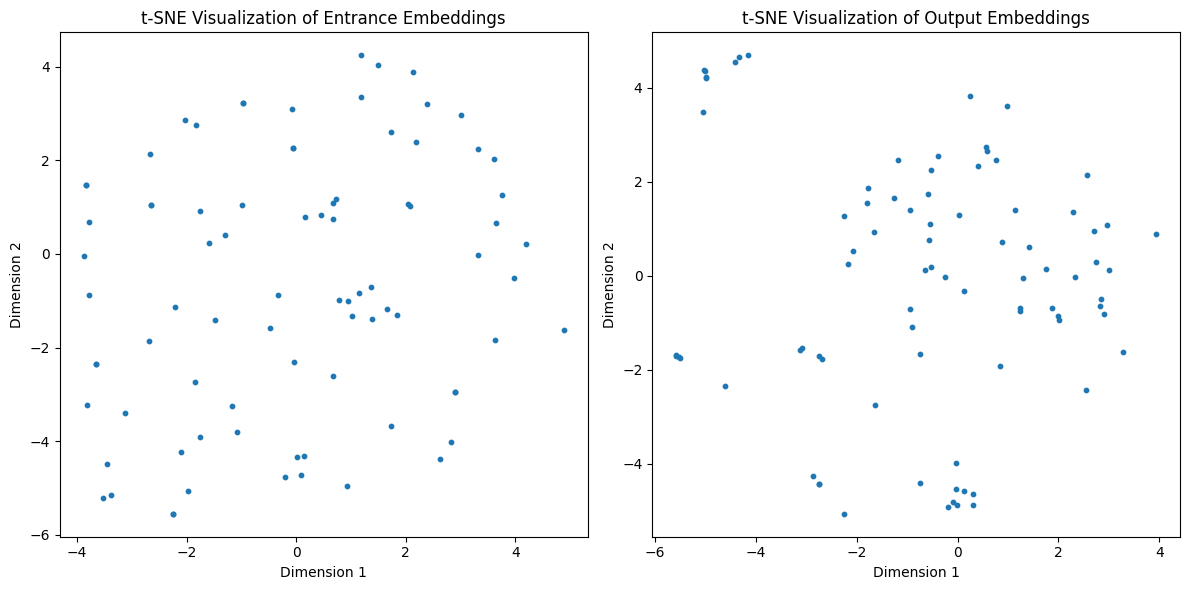

In [ ]:
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt

# d- Make a t-SNE visualization of the token embeddings for the entrance embeddings and for the output embeddings

# Compute cosine similarity matrix
cosine_sim_matrix = cosine_similarity(entrance_embeddings)

# Due to some numerical precision issues, cosine similarities are slightly below -1 and above 1
cosine_sim_matrix_clip = np.clip(cosine_sim_matrix, -1, 1)

# Perform t-SNE on entrance embeddings
entrance_tsne = TSNE(n_components=2, metric='precomputed', init='random', random_state=0, method='exact').fit_transform(1 - cosine_sim_matrix_clip)
print('Shape of the projection entrance_tsne:', entrance_tsne.shape)

# Compute cosine similarity matrix for output embeddings
cosine_sim_matrix_output = cosine_similarity(output_embeddings)
cosine_sim_matrix_output_clip = np.clip(cosine_sim_matrix_output, -1, 1)

# Perform t-SNE on output embeddings
output_tsne = TSNE(n_components=2, metric='precomputed', init='random', random_state=0, method='exact').fit_transform(1 - cosine_sim_matrix_output_clip)
print('Shape of the projection output_tsne:', output_tsne.shape)

# Plot t-SNE visualizations
plt.figure(figsize=(12, 6))

# Entrance embeddings plot
plt.subplot(1, 2, 1)
plt.scatter(entrance_tsne[:, 0], entrance_tsne[:, 1], marker='o', s=10)
plt.title('t-SNE Visualization of Entrance Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Output embeddings plot
plt.subplot(1, 2, 2)
plt.scatter(output_tsne[:, 0], output_tsne[:, 1], marker='o', s=10)
plt.title('t-SNE Visualization of Output Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.tight_layout()
plt.show()

Performing t-SNE visualization on all occurrences of a selected token provides a comprehensive view of how BERT embeddings represent the contextual relationships of that token in the data.

* In the **t-SNE Visualization of Entrance Embeddings** we can see that the embeddings are spread out in the embedding space. There are also a lot of isolated points in the plot.

* In the **t-SNE Visualization of Output Embeddings** we can see some clusters in the embedding space. Indeed, it indicates similarities between tokens because they are closer to each other. Moreover, there are not to much isolated points in this figure.

We can conclude that different layers capture different aspects of contextual information. Indeed the **t-SNE Visualization of Output Embeddings** captures more clusters than the **t-SNE Visualization of Entrance Embeddings**.

I think it is indicative of how information is transformed and refined as it propagates through the layers of the BERT model.
At the initial layer (layer 0), the embeddings may not yet differentiat the context in which all occurrences are used. This is because layer 0 might provide more basic, context-independent representations. The embeddings at the entrance may not contain sufficient contextual information to form distinct clusters.

However, the presence of specific clusters in the t-SNE plot for Output Embeddings suggests that as the information passes through the layers of the BERT model, it becomes more refined. BERT's strength in understanding context becomes more apparent in later layers.

**Differences with word2vec:**

Unlike BERT, Word2Vec embeddings are context-independent. Each occurrence of a token is represented by the same vector, regardless of its context in a sentence.
So we will have 1 point in the embedded space for that token because each occurrence of the token would be associated with the same vector representation in the embedded space.

In [ ]:
#
# TODO
#
# The encoder provides two (direct) ways to embed utterances: in practice, we often use the embedding of the
# [CLS] token as an embedding of the utterance; one can also use the pooler_output attribute of the encoder
# which corresponds to a projection of the [CLS] token embedding through a feed-forward layer trained for the
# next sentence prediction objective of BERT training. Note that some folks also consider the average of the
# token embeddings taken at the last layer (a strategy known as _average pooling_), which we will not consider
# here.
#
# Following the same idea as for token embeddings, we want to visualize with t-SNE the properties of these two
# main document embedding strategies and see how well (or not) the two classes are separated. As for token
# embeddings, the cosine similarity distance is an appropriate way to compare utterance embeddings.
#
# What you need to do is thus:
#   - an array where each line is an utterance embedding (either [CLS] or pooler_output)
#   - t-SNE plot of the rows of the array, differentiating positive and negative examples
#
# Q: Comment the results. Are the two classes easily separable for those two representations? Is one
# representation apparently better than the other? And why according to you? Do you think a vector space model
# with tf-idf representation be better (no need to do the implementation unless you have time on your hand,
# I'm rather interested in your intuition).
#

In [ ]:
# 1st method:

# outputs = encoder(X)

# # 1. Extract embeddings for each utterance
# cls_embeddings = outputs['last_hidden_state'][:, 0].numpy()
# pooler_embeddings = outputs['pooler_output'].numpy()

# # Extract labels
# labels = np.array([y[i] for i in range(len(small))])

# # 2. Create an array where each line represents the embedding of an utterance
# cls_embeddings_array = np.array(cls_embeddings)
# pooler_embeddings_array = np.array(pooler_embeddings)

# print(cls_embeddings_array.shape)
# print(pooler_embeddings_array.shape)

ResourceExhaustedError: Exception encountered when calling layer 'embeddings' (type TFBertEmbeddings).

{{function_node __wrapped__ResourceGather_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[4000,512,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ResourceGather] name: 

Call arguments received by layer 'embeddings' (type TFBertEmbeddings):
  • input_ids=tf.Tensor(shape=(4000, 512), dtype=int32)
  • position_ids=None
  • token_type_ids=tf.Tensor(shape=(4000, 512), dtype=int32)
  • inputs_embeds=None
  • past_key_values_length=0
  • training=False

**Problem:**

I have deliberately keep the code above in comment (with the error associated) as it doesn't work.

I cannot compute `encode(X)` where X= tokenizer([x[1] for x in small], return_tensors="tf", padding=True, truncation=True), it leads to an error of type `'ResourceExhaustedError'`. When I compute the encoder for the whole dataset, the amount of RAM is always exceeded.
So, I used a different method. In the code below, for each line/sequence in the dataset, I convert the token ids into tensor and then I use the function `encoder(utterance)` to avoid this problem of memory.

In [ ]:
cls_embeddings = []
pooler_embeddings = []
labels = []
batch_size = 32

# 1. Extract embeddings for each utterance
for i in tqdm(range(0, len(X['input_ids']), batch_size)):

    utterance = X['input_ids'][i:i+batch_size]
    outputs = encoder(utterance, return_dict=True)

    # Use embedding of the CLS token
    cls_embeddings.extend(outputs['last_hidden_state'][:, 0].numpy())

    # Use embedding of the pooler_output attribut
    pooler_embeddings.extend(outputs['pooler_output'].numpy())

    # Add the y's in a list called labels
    labels.extend(y[i:i+batch_size])
labels = np.array(labels)

# 2. Create an array where each line represents the embedding of an utterance
cls_embeddings_array = np.array(cls_embeddings)
pooler_embeddings_array = np.array(pooler_embeddings)

100%|██████████| 125/125 [00:49<00:00,  2.52it/s]


In line 4, I indicated a batch_size. Indeed, instead of applying the loop for each sequence of the dataset (which takes a lot of time), I used a batch_size of 32 which considerably reduces the execution time.


In line 13, `outputs['last_hidden_state'][:, 0]` is referring to:

*   '$[:,..]$' indicates all rows (representing different sequences in the batch).
*   '$[..,0]$' is the first element along the second dimension (the sequence length). It means that we take the first position corresponding to [CLS] (first token).

So to resume `cls_embedding` extracts the hidden state of the [CLS] token for all the sequences in the batch.

Then, in line 16, `outputs['pooler_output']` represents the embedding of an utterance obtained from the pooler output. It is obtained by taking the hidden state corresponding to the [CLS] token and passing it through an additional feed-forward layer. I extracted the numpy representation of this pooled output for the sequences in the batch.


The code below provides a t-SNE visualization of the utterance embeddings, differentiating positive and negative examples.

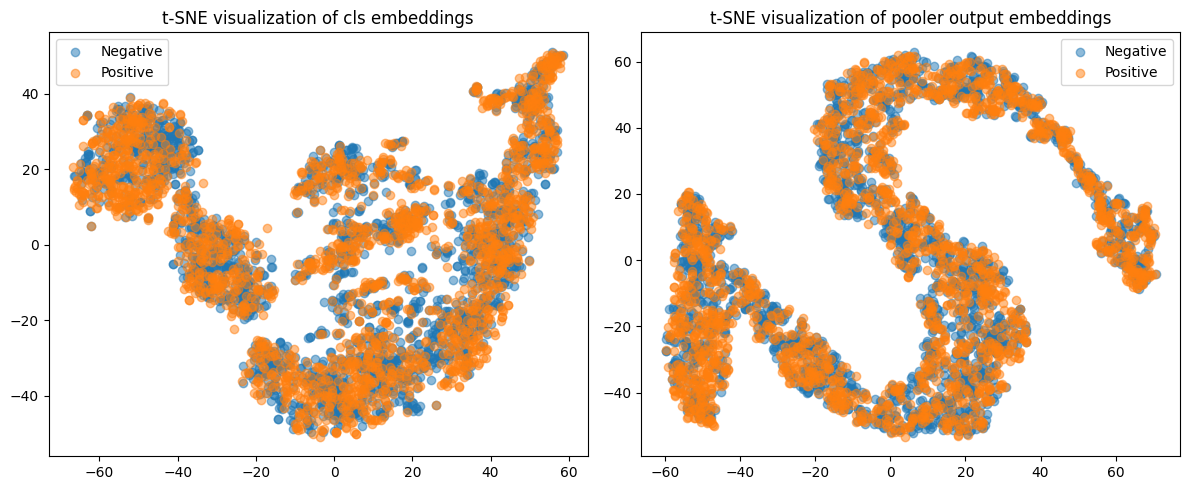

In [ ]:
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt

# 3. Perform t-SNE on the array and visualize the embeddings

# Compute cosine similarity matrix
cosine_sim_matrix_cls = cosine_similarity(cls_embeddings_array)
cosine_sim_matrix_cls_clip = np.clip(cosine_sim_matrix_cls, -1, 1)

cosine_sim_matrix_pooler = cosine_similarity(pooler_embeddings_array)
cosine_sim_matrix_pooler_clip = np.clip(cosine_sim_matrix_pooler, -1, 1)

cls_tsne = TSNE(n_components=2, metric='precomputed', init='random', random_state=0, method='exact').fit_transform(1 - cosine_sim_matrix_cls_clip)
pooler_tsne = TSNE(n_components=2, metric='precomputed', init='random', random_state=0, method='exact').fit_transform(1 - cosine_sim_matrix_pooler_clip)

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(cls_tsne[labels == 0, 0], cls_tsne[labels == 0, 1], label='Negative', alpha=0.5)
plt.scatter(cls_tsne[labels == 1, 0], cls_tsne[labels == 1, 1], label='Positive', alpha=0.5)
plt.title('t-SNE visualization of cls embeddings')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(pooler_tsne[labels == 0, 0], pooler_tsne[labels == 0, 1], label='Negative', alpha=0.5)
plt.scatter(pooler_tsne[labels == 1, 0], pooler_tsne[labels == 1, 1], label='Positive', alpha=0.5)
plt.title('t-SNE visualization of pooler output embeddings')
plt.legend()

plt.tight_layout()
plt.show()

* `cosine_sim_matrix_cls_clip` clips the values of the cosine similarity matrix for [CLS] embeddings between -1 and 1.
* `cosine_sim_matrix_pooler_clip` clips the values of the cosine similarity matrix for pooler embeddings between -1 and 1.

The parameters of the TSNE are the following:
* `n_components=2` means that we set the dimension of the embedded space to 2.
* `'precomputed'` indicates that the input data (cosine similarity) is already a precomputed distance matrix.
* `'random'` initializes the points in the embedded space randomly.

* Then, the scatter plots are created for both [CLS] embeddings and pooler embeddings using t-SNE results, differentiating between positive and negative examples.
* `cls_tsne[labels == 0, 0]` extracts the values of the first dimension (index 0) for the elements in cls_tsne corresponding to the elements where labels is equal to 0. It filters out the t-SNE values for negative examples in the first dimension.
* `cls_tsne[labels == 0, 1]` extracts the values of the second dimension (index 1) for the elements in cls_tsne corresponding to the elements where labels is equal to 0.
* same for labels equal to 1

In the token [CLS] embedding no class forms a distinct cluster from the other. Same thing for the pooler output embeddings. The two classes are not easely separable in the two representations.

**Differences with a TF-IDF model:**

A TF-IDF representation in a vector space model is different from contextual embeddings like BERT. It relies on term frequency and inverse document frequency to evaluate the importance of a term contained in a document, relative to a collection or corpus.
However, TF-IDF doesn't capture semantic relationships between words or contextual information, which may limit its performance on tasks requiring understanding of context compare to BERT.

## A basic feed-forward classifier on top of utterance embeddings

The first neural classifier that we will build is rather trivial: we will simply build a basic feed-forward classifier that takes as input either one of the utterance embeddings from the previous step and run two
fully-connected layers towards the final decision.

Here are a few hints to help you with the construction of such a model in Keras. Building a model in keras follows a three step process:
1. define the model architecture
2. _compile_ the model with a loss function and an optimizer
3. _fit_ the model parameters on training data, monitoring the behavior of the model on validation data

You can get examples and more details in the labwork text that was provided.

### Define the model architecture

There are two main ways to define a keras model. The first one use a _sequential_ API where we define layers in a serial way, each layers being implicitely connected. For a two layer feed-forward network, that will look like

    idim = encoder.hidden_size
    dim1 = 256
    dim2 = 128
    odim = 1 # 1 if binary_crossentropy loss is used, number of classes if categorical_crossentropy or sparse_categorical_crossentropy is used

    model = Sequential()
    model.add(Dense(dim1, input_shape=(idim,), activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(dim2, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(2), activation='softmax') # if we want a two dimensional output

The second option is known as the _functional_ API where the operations between layers is made explicit, the model being implicitely created from the sequence of operations that you define. Disregarding dropout, this would look like

    inputs = tf.keras.Input(shape=(idim,)) # an empty layer to materialize what the input will be
    x1 = tf.keras.layers.Dense(dim1, activation=tf.nn.relu)(inputs)
    x2 = tf.keras.layers.Dense(dim2, activation=tf.nn.relu)(x1)
    outputs = tf.keras.layers.Dense(2, activation=tf.nn.softmax)(x2)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

### Compile the model

You have to specify a loss function that will measure how well the classifier predicts training data. There are two options here since we're considering a binary classification task with 0/1 labels:
- output prediction is a single activation value (either 0 or 1), in which case the appropriate loss function is the binary crossentropy
- output prediction is a two-valued vector with class probabilities, in which case the appropriate loss function is
the sparse categorical cross-entropy (assuming reference labels are 0/1 values -- if you want to use 1-hot encoding of the labels rather as in the labwork text example, categorical cross-entropy is your friend)

As for the optimizer, we will keep it very basic and simply use the Adam optimizer with default parameters in this case.

In its simplest form, this gives something like:

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
    model.summary()

but much more complex variants can be used: see Keras documentation if you're interested.

### Fit the model

Assuming you have a numpy array X_train (or simply a list) with the input embeddings to train on (number of samples x input dimension) and the corresponding labels in a y_train vector (of 0s and 1s), fitting is a simple call to something like

    model.fit(X_train, y_train, batch_size=32, epochs=10)

You can specify validation data and metrics to report progress, e.g.,

    model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data = (X_val, y_val), metrics=['accuracy'])

You can alternately not specify validation data and simply ask fit() to reserve x% of the training data for validation with the argument validation_split = x/100. See the LSTM example of lecture 3 for instance.

### Precit or evaluate the model

You can use model.evaluate() or model.predict() to measure how well your model is doing on the test data. See accompanying labwork text for details.

In [ ]:
#
# TODO
#
# Load the entire IMDb dataset, separate test data and possibly validation data (your choice to use or not an
# explicit validation set) and prepare the X_train and y_train inputs for training, X_test and y_test for
# evaluation (and possibly X_valid, y_valid) with either one of the utterance embeddings from the previous
# question.
#
# Define a model, train it and evaluate it. You can play a bit with the parameters (dropout, dim1/dim2) and see
# where it takes us. How does that compare to what we did with the vector space model with tf-idf weights along
# with a k-nn classification?
#

The aim is to predict either if the sentences from the dataset are positive or negative (0 or 1).

In [ ]:
# 1. Shuffle the dataset

np.random.seed(39)
# Combine embeddings with the labels in a single array
combined_data = np.column_stack((cls_embeddings_array, labels))
print(combined_data.shape)

# Shuffle the combined data
shuffled_data = np.random.permutation(combined_data)
print(shuffled_data[:,-1][:10])

# 2. Separate train, test and validation data (60/20/20)

# Split the data into training, validation, and test sets
total_samples = len(shuffled_data)
train_split = int(0.6 * total_samples)
val_split = int(0.8 * total_samples)

train_data = shuffled_data[:train_split]
val_data = shuffled_data[train_split:val_split]
test_data = shuffled_data[val_split:]

# Separate features and labels
X_train, y_train = train_data[:, :-1], train_data[:, -1]
X_val, y_val = val_data[:, :-1], val_data[:, -1]
X_test, y_test = test_data[:, :-1], test_data[:, -1]

# Check the shapes of the datasets
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('\n-----\n')
print('X_valid shape:', X_val.shape)
print('y_valid shape:', y_val.shape)
print('\n-----\n')
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

(4000, 769)
[0. 1. 1. 0. 0. 0. 1. 0. 1. 1.]
X_train shape: (2400, 768)
y_train shape: (2400,)

-----

X_valid shape: (800, 768)
y_valid shape: (800,)

-----

X_test shape: (800, 768)
y_test shape: (800,)


* ```X_train``` extracts all columns of the train_data except the last one. The last one is the label's column.

* ```y_train``` extracts only the last column.
* Same for validation and test values.

In [ ]:
# 3. Define the model architecture

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

idim = 768  # Utterance embeddings have a dimension of 768
dim1 = 256
dim2 = 128
odim = 1  # For binary classification

model = Sequential()
model.add(Dense(dim1, input_shape=(idim,), activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(dim2, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(odim, activation='sigmoid'))  # Using 'sigmoid' for binary classification

The model I created is a basic feed-forward neural network for binary classification. First of all, the input dimension is set to 768, which corresponds to the dimensionality of the utterance embeddings obtained from the BERT model previously. I use 3 dense layers where the first one has dim1 = 256 and it uses the activation function ReLU and takes the input shape of idim. A dropout layer is applied after the first dense layer with a dropout rate of 0.2.
This prevent from overfitting. Then I use the second dense layer of dimension dim2 = 128. Another dropout layer is applied after the second hidden layer. Finally, the output layer has a single unit with a sigmoid activation function. Sigmoid is used for binary classification, as it squashes the output between 0 and 1, representing the probability of the positive class.


In [ ]:
# 4. Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               196864    
                                                                 
 dropout_37 (Dropout)        (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_38 (Dropout)        (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 229889 (898.00 KB)
Trainable params: 229889 (898.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The model is compiled using the Adam optimizer and binary cross-entropy loss, which is suitable for binary classification problems.

In [ ]:
# 5. Fit the model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
75/75 [==============================] - 3s 6ms/step - loss: 0.7089 - accuracy: 0.5525 - val_loss: 0.6624 - val_accuracy: 0.5863
Epoch 2/10
75/75 [==============================] - 0s 4ms/step - loss: 0.6676 - accuracy: 0.5954 - val_loss: 0.6535 - val_accuracy: 0.5825
Epoch 3/10
75/75 [==============================] - 0s 5ms/step - loss: 0.6269 - accuracy: 0.6450 - val_loss: 0.6079 - val_accuracy: 0.6687
Epoch 4/10
75/75 [==============================] - 0s 4ms/step - loss: 0.5945 - accuracy: 0.6829 - val_loss: 0.6199 - val_accuracy: 0.6313
Epoch 5/10
75/75 [==============================] - 0s 4ms/step - loss: 0.5832 - accuracy: 0.6842 - val_loss: 0.5628 - val_accuracy: 0.6963
Epoch 6/10
75/75 [==============================] - 0s 4ms/step - loss: 0.5710 - accuracy: 0.6925 - val_loss: 0.5432 - val_accuracy: 0.7262
Epoch 7/10
75/75 [==============================] - 0s 4ms/step - loss: 0.5510 - accuracy: 0.7175 - val_loss: 0.5439 - val_accuracy: 0.7200
Epoch 8/10
75/75 [==

The model is trained using the training data (X_train, y_train) with a batch size of 32, over 10 epochs. Validation data (X_val, y_val) are provided to monitor the model's performance during training and prevent overfitting.

In [ ]:
# 6. Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy * 100:.2f}%')

25/25 [==============================] - 0s 3ms/step - loss: 0.5121 - accuracy: 0.7500
Test Loss: 0.5121
Test Accuracy: 75.00%


The model is evaluated on the test data (X_test and y_test) and the test loss and accuracy are printed. Globally the accuracy is quite good meaning that 75 % of the labels were correctly classified.

In [ ]:
# 7. Predict the model
predictions = model.predict(X_test)
binary_predictions = (predictions > 0.5).astype(int)
print("Predictions of the model:", binary_predictions[:10]) # only the 10th first values
print("True labels", y_test[:10])

25/25 [==============================] - 0s 2ms/step
Predictions of the model: [[1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]]
True labels [1. 1. 0. 1. 0. 1. 1. 1. 0. 1.]


The model is used to predict labels for the test data, and the first 10 predictions are printed along with the true labels. Here we have some misclassified data. For example, in index 4 we predicted 1 but it was 0.

**How can we improve our model ?**

We can improve our model by training the model on the whole dataset to have more diverse examples to generalize well. Or we could actually fine-tune the BERT model on the specific task to better capture domain-specific features. Lastely, we could experiment with different hyperparameters to find the best configuration.



**How does that compare to what we did with the vector space model with tf-idf weights along with a k-nn classification?**

On the one hand, it is different in term of tuning the hyperparameters. With k-nn we select the value of k and we consider other factors such as the distance metric. In the labs we saw the cosine metric. Moreover the training is fast. We know that in tf-idf it doesn't capture contextual information.
However, for training a classifier for utterance embeddings as input we have to consider dropout rates, learning rates, and model dimensions. It also requires training a neural network, involving backpropagation and optimization. It can be computationally expensive.

In the second hand for k-nn with tf-idf, we convert the utterrances in tf-idf vectors. Then, the predictions are based on the similarity of vectors in the vector space.
However, for models which uses BERT embeddings it captures complex patterns and semantics, which is beneficial for understanding the context in the sequences.

## A recurrent classifier

The second classifier that we consider is a direct application of recurrent neural networks. It is similar to what we did for language modeling except that it takes as input a tokenized version of the utterance that might contain
padding to ensure all input sequences have the same length. We will directly use BERT's tokenizer with padding and adapt the small LM example we played with in lecture 3 to perform class prediction rather than next token prediction. The model features an embedding layer whose input size is the number of tokens in the tokenizer's vocabulary (which can be accessed through tokenizer.vocab_size or, if you prefer, simply going through your data to see who's present), a LSTM layer that processes the input sequence, one or several fully connected classification layers that takes as input the state of the last LSTM cell. Optimizer and loss are the same as for the feed-forward architecture.


In [ ]:
#
# TODO
#
# With the above explanations, the example from lecture 3 on language generation with LSTM, a little inspiration
# from the labwork text that accompanies the project, you should be able to define, train and evaluate a LSTM
# model for text classification and compare it with we've done so far. You can play with the parameters (embedding
# size, hidden dim in LSTM).
#
# If you feel like going further, you can try BiLSTM (simply replace LSTM layer by BiLSTM layer) and/or
# hierarchical LSTMs. And if very very curious, replace the LSTM cell by a GRU one.
#


The aim is to train a LSTM model to be able to predict either if the sentence is positive or negative (0 or 1) giving the IMDb dataset.

In [ ]:
from sklearn.model_selection import train_test_split
import random

# 1. Use tokenize version of the utterance with padding
np.random.seed(40)

fn = "/content/drive/My Drive/Smart-Data/NLP/imdb-trn.json"

with open(fn, 'rt') as f:
    imdb_data = json.load(f)

# Generate data
recurrent_data = imdb_data[:2000] + imdb_data[-2000:]
sentences = [x[1] for x in recurrent_data]
labels = [1 if x[0] == 'pos' else 0 for x in recurrent_data]

# zip function is used to combined the 2 lists to create a tuple
combined_data = list(zip(sentences, labels))

# Shuffle the combined data
random.shuffle(combined_data)
shuffled_sentences, shuffled_labels = zip(*combined_data)

# Convert to fixed sequence of token ids
shuffled_sentences_tok = tokenizer(shuffled_sentences, padding=True, truncation=True, return_tensors='tf')
input_ids = np.array(shuffled_sentences_tok['input_ids'])

# Split the shuffled data into training (60%) set
train_sentences, temp_sentences, train_labels, temp_labels = train_test_split(
    input_ids, shuffled_labels, test_size=0.4, random_state=42
)

# Split the remaining data into testing (50%) and validation (50%) sets
test_sentences, val_sentences, test_labels, val_labels = train_test_split(
    temp_sentences, temp_labels, test_size=0.5, random_state=42
)

# Convert lists to NumPy arrays
X_train = np.array(train_sentences)
y_train = np.array(train_labels)
X_val = np.array(val_sentences)
y_val = np.array(val_labels)
X_test = np.array(test_sentences)
y_test = np.array(test_labels)

# Check the shapes of the datasets
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('\n-----\n')
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)
print('\n-----\n')
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (2400, 512)
y_train shape: (2400,)

-----

X_val shape: (800, 512)
y_val shape: (800,)

-----

X_test shape: (800, 512)
y_test shape: (800,)


In line 25, the sequence length (number of words) in each sequence varies, so I constrained each sequence to be 512 words with `padding = True` and truncating long texts.

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# 2. Define the LSTM model architecture
vocsize = tokenizer.vocab_size
embedding_size = X_train.shape[1]
lstm_size = 100

model_lstm = Sequential()
model_lstm.add(Embedding(vocsize, lstm_size, input_length = embedding_size))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(lstm_size))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1, activation='sigmoid'))

The model begins with an Embedding layer, which is responsible for converting tokenized input sequences into dense vectors of fixed size (embedding vectors). This actually called **word embedding**.
The input vocabulary size is equal to `vocsize`. It is a variable that represents the size of the vocabulary used by the tokenizer. It indicates the total number of unique tokens (words or subwords) present in the vocabulary.
`embedding_size` represents the length of the embedding vectors and is set to the size of the input sequences.
The Embedding layer output is fed into an LSTM (Long Short-Term Memory) layer. It is a layer which has the ability to memorize important information over long sequences and ignore less relevant elements.

We talked in class that LSTM networks are a variation of recurrent neural networks (RNN). It addresses the issue of vanishing gradient commonly encountered when training recurrent neural networks (RNN). It occurs when RNNs attempt to model long-term dependencies in sequences. For example, when words at the beginning of a sentence have a significant influence on the meaning of the whole sentence. When the network tries to learn those long terms relations the gradients become smaller and smaller specially for the neurons based at the beginning of the sequence. As a result, updates to the weights associated with these neurons near the start of the sequence become negligible. RNNs have difficulty learning and capturing long-term dependencies. To mitigate this problem, LSTMs have been proposed. They use regulatory mechanisms to avoid vanishing gradients and effectively capture long-term dependencies in sequences.

`lstm_size` represents the number of LSTM units or cells in the layer.

Then another dropout layer is added to the model. Finally, the LSTM layer output is then passed through a Dense layer with a single neuron and a sigmoid activation function.

In [ ]:
# 3. Compile the model
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model_lstm.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 512, 100)          2899600   
                                                                 
 dropout_38 (Dropout)        (None, 512, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_39 (Dropout)        (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2980101 (11.37 MB)
Trainable params: 2980101 (11.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


The model is compiled using the Adam optimizer and binary cross-entropy loss, which is suitable for binary classification problems.

In [ ]:
# 4. Train the model
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
75/75 [==============================] - 14s 161ms/step - loss: 0.6935 - accuracy: 0.5054 - val_loss: 0.6930 - val_accuracy: 0.5250
Epoch 2/10
75/75 [==============================] - 10s 136ms/step - loss: 0.6899 - accuracy: 0.5279 - val_loss: 0.6952 - val_accuracy: 0.4938
Epoch 3/10
75/75 [==============================] - 10s 131ms/step - loss: 0.6773 - accuracy: 0.5267 - val_loss: 0.6999 - val_accuracy: 0.5175
Epoch 4/10
75/75 [==============================] - 8s 105ms/step - loss: 0.7188 - accuracy: 0.5300 - val_loss: 0.6929 - val_accuracy: 0.5250
Epoch 5/10
75/75 [==============================] - 8s 104ms/step - loss: 0.6947 - accuracy: 0.5229 - val_loss: 0.6918 - val_accuracy: 0.5225
Epoch 6/10
75/75 [==============================] - 7s 88ms/step - loss: 0.6923 - accuracy: 0.5138 - val_loss: 0.6922 - val_accuracy: 0.5225
Epoch 7/10
75/75 [==============================] - 8s 103ms/step - loss: 0.6814 - accuracy: 0.5275 - val_loss: 0.7052 - val_accuracy: 0.5138
Epoc

The model is trained using the training data (X_train, y_train) with a batch size of 32, over 10 epochs. Validation data (X_val, y_val) are provided to monitor the model's performance during training and prevent overfitting.

In [ ]:
# 5. Evaluate the model
loss, accuracy = model_lstm.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy * 100:.2f}%")

25/25 [==============================] - 0s 11ms/step - loss: 0.7197 - accuracy: 0.5013
Test Loss: 0.7196900844573975, Test Accuracy: 50.13%


The model is evaluated on the test data (X_test and y_test) and the test loss and accuracy are printed. The model correctly classified about half of the examples in the test set. Globally the model doesn't perform well on the test data. This could suggest that the LSTM model has not effectively learned to represent and understand relationships in text sequences for this specific task. Adjusting the model's hyperparameters or exploring other neural network architectures could potentially improve performance. In addition, a more complex model or longer training could be considered to improve the model's ability to learn useful representations in the data.

In [ ]:
# 6. Predict the model
predictions = model_lstm.predict(X_test)
binary_predictions = (predictions > 0.5).astype(int)
print("Predictions of the model:", binary_predictions[:10]) # only the 10th first values
print("True labels", y_test[:10])

25/25 [==============================] - 1s 10ms/step
Predictions of the model: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
True labels [0 1 0 1 0 1 1 1 0 1]


We can see that some of the labels where misclassified. For example the second prediction (0) is incorrect, as it does not match the true label (1). I don't have a good accuracy maybe because the sequences of the IMDb dataset are not very long or do not contain significant temporal dependencies.

## Thre Graal: fine-tune a BERT model with a text classification head

**To remove:**

For instance, I want you to briefly reexplain what the models are doing from a theoretical point of view for step 3, 4 and 5 before running the implementation (concretely, briefly reexplain what we saw in the classroom). I also want you to comment the results and analyze a few examples that were misclasified, trying to figure out why and, if possible, relate this to the limits of the classification method used. I'm also expecting thoughts on how things could be improved. Don't expect me to simply run your notebook and check that it works: in most cases, I will not even try to run things and simply look at the comments and analyses you will provide.

Train BERT (Bidirectional ):

* Segment: sentence encoding (whether you  are in the sentence or in the second sentence).
* Positional embedding
* Token


In this part we are going to fine-tune our BERT model by adding a classification head to the output of the encoder. The classification head is a simple feedforward network (like in step 3) that predicts the class label for each text input.

First of all we are going to load the pre-trained model by using `TFBertForSequenceClassification` from the transformers library. It has been trained on massive datasets of text. During pre-training, the model is exposed to large amounts of unlabeled text and learns to predict missing or masked words within a sentence. BERT considers both the left and right context of each word (bidirectional).This allows to learn a general understanding of language, which can be helpful for a variety of NLP tasks.

We will train our model on this pre-trained model on our specific task which is the IMDb dataset which contains texts and labels. To do so we define a new classification head. The classification head is a feedforward network that predicts the class label for each text input.
The benefits of fine-tuning is that it can be faster and easier than training a model from scratch and it can achieve better performance.

In [ ]:
from transformers import TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# 1. Use tokenize version of the utterance (plus attention masks and token type IDs)
input_ids = np.array(shuffled_sentences_tok['input_ids'])
attention_mask = np.array(shuffled_sentences_tok['attention_mask'])
token_type_ids = np.array(shuffled_sentences_tok['token_type_ids'])

# Split the shuffled data into training (60%) set
train_input_ids, temp_input_ids, train_labels, temp_labels, train_attention_mask, temp_attention_mask, train_token_type_ids, temp_token_type_ids = train_test_split(
    input_ids, shuffled_labels, attention_mask, token_type_ids, test_size=0.4, random_state=42
)

# Split the remaining data into testing (50%) and validation (50%) sets
test_input_ids, val_input_ids, test_labels, val_labels, test_attention_mask, val_attention_mask, test_token_type_ids, val_token_type_ids = train_test_split(
    temp_input_ids, temp_labels, temp_attention_mask, temp_token_type_ids, test_size=0.5, random_state=42
)

# Convert lists to NumPy arrays
train_inp = np.array(train_input_ids)
train_lab = np.array(train_labels)
train_mask = np.array(train_attention_mask)
train_token_type = np.array(train_token_type_ids)

val_inp = np.array(val_input_ids)
val_lab = np.array(val_labels)
val_mask = np.array(val_attention_mask)
val_token_type = np.array(val_token_type_ids)

test_inp = np.array(test_input_ids)
test_lab = np.array(test_labels)
test_mask = np.array(test_attention_mask)
test_token_type = np.array(test_token_type_ids)

# Check the shapes of the datasets
print('train_inp shape:', train_inp.shape)
print('train_lab shape:', train_lab.shape)
print('train_mask shape:', train_mask.shape)
print('train_token_type shape:', train_token_type.shape)
print('\n-----\n')
print('val_inp shape:', val_inp.shape)
print('val_lab shape:', val_lab.shape)
print('val_mask shape:', val_mask.shape)
print('val_token_type shape:', val_token_type.shape)
print('\n-----\n')
print('test_inp shape:', test_inp.shape)
print('test_lab shape:', test_lab.shape)
print('test_mask shape:', test_mask.shape)
print('test_token_type shape:', test_token_type.shape)

train_inp shape: (2400, 512)
train_lab shape: (2400,)
train_mask shape: (2400, 512)
train_token_type shape: (2400, 512)

-----

val_inp shape: (800, 512)
val_lab shape: (800,)
val_mask shape: (800, 512)
val_token_type shape: (800, 512)

-----

test_inp shape: (800, 512)
test_lab shape: (800,)
test_mask shape: (800, 512)
test_token_type shape: (800, 512)


`shuffled_sentences_tok` contains the input_ids and the attention_mask and token type ids.

* In line 6, `input_ids` will get the token ids of all the sentences in BERT.
* `attention_mask` will get the the attention mask which control which tokens should be attended to and which ones should be ignored.
* `token_type_ids` are used to differentiate between the different segments in the input. The model learns to use this information to understand the relationships between different segments in the context of the task.


We will see that the self-attention mechanism enables the model to weigh the importance of each word based on the entire context, leading to rich contextualized embeddings.

In the code above, I did split the data into training, testing and validation set in the same way as the LSTM model. However, there is a change here. I use the BERT tokenizer which tokenize all the sequences in the data. I then extract from the tokenizer the token ids, the attention mask and the input type ids. Then, with this three, I use them to create a model for classification.

In [ ]:
# 2. Define the pre-trained model for fine-tuning
bert_model = TFBertForSequenceClassification.from_pretrained(checkpoint)

Training a BERT model from scratch on a small dataset would result in overfitting. So we use a pre-trained BERT model that was trained on a huge dataset, as a starting point. We can then further train the model on our relatively smaller dataset and this process is known as model fine-tuning.

In [ ]:
# 3. Create a model for classification
# max_sequence_length = 512
# input_ids = tf.keras.Input(shape=(max_sequence_length,), dtype=tf.int32, name="input_ids")
# attention_mask = tf.keras.Input(shape=(max_sequence_length,), dtype=tf.int32, name="attention_mask")
# token_type_ids = tf.keras.Input(shape=(max_sequence_length,), dtype=tf.int32, name="token_type_ids")

outputs = bert_model([shuffled_sentences_tok['input_ids'], shuffled_sentences_tok['attention_mask'], shuffled_sentences_tok['token_type_ids']])[0]
drop = tf.keras.layers.Dropout(0.4)(outputs)
classification_head = tf.keras.layers.Dense(1, activation='sigmoid')(drop)
model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=classification_head)

The input_ids, attention_mask and token_type_ids are then added to the bert layer. In line 7, `outputs` performs a forward pass through the BERT model, taking the tokenized input, attention mask and token type IDs. It produces an output tensor.

`classification_head` convert the output into predicted probabilities for each class. The sigmoid function is used for binary class.

`model`, in line 9, specifies the input tensors which include [input_ids, token_type_ids, attention_mask] for the model. It also specifies the output tensor for the model which is `classification_head`.

The bert_model is encapsuled into a new model which we can use for inference.



In [ ]:
# 4. Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.BinaryCrossentropy()
metric = tf.keras.metrics.BinaryAccuracy('binary_accuracy')
model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

The model is compiled using the Adam optimizer and binary cross-entropy loss, which is suitable for binary classification problems.

In [ ]:
# 5. Train the model
history = model.fit([train_inp, train_mask, train_token_type], train_lab, batch_size=16, epochs=3, validation_data=([val_inp, val_mask, val_token_type], val_lab))

Epoch 1/3


ResourceExhaustedError: Graph execution error:

Detected at node model_2/tf_bert_for_sequence_classification/bert/encoder/layer_._11/attention/self/Softmax defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-18-dbdfb755990d>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_utils.py", line 1557, in run_call_with_unpacked_inputs

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 1569, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_utils.py", line 1557, in run_call_with_unpacked_inputs

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 862, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 548, in call

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 554, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 464, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 380, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 319, in call

  File "/usr/local/lib/python3.10/dist-packages/transformers/tf_utils.py", line 70, in stable_softmax

OOM when allocating tensor with shape[16,12,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_2/tf_bert_for_sequence_classification/bert/encoder/layer_._11/attention/self/Softmax}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_76138]

The model is trained using the training data ([train_inp, train_mask, train_token_type], train_lab) with a batch size of 16, over 3 epochs. Validation data ([val_inp, val_mask, val_token_type], val_lab) are provided to monitor the model's performance during training and prevent overfitting.

In [ ]:
# 6. Evaluate the model
test_loss, test_accuracy = bert_model.evaluate([val_inp, val_mask, val_token_type], batch_size=32)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

In [ ]:
# 7. Prediction of the model
predictions = bert_model.predict([val_inp, val_mask, val_token_type], batch_size=32)
pred_labels = predictions.argmax(axis=1)
f1 = f1_score(val_lab, pred_labels)
print('F1 score', f1)

`predictions` gives the probability of the labels. Then we apply argmax and obtain the predicted labels. We take the argmax in axis=1 and get the label of the maximum probability.